This code is the dummy code that:

Input: 
- random "fidelity" F from 0 to 1
- property P that was calculated from F

Output:
- Macchine learned `model` that given P output a predicted F

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from qutip import *
import matplotlib.pyplot as plt
from visualisation_tools import *

In [2]:
# --- Define the ideal case ---

# Ideal state |+><+|
plus_state = (basis(2,0) + basis(2,1)).unit()
rho_ideal = plus_state * plus_state.dag()

# Ideal channel: S gate
S_gate = Qobj([[1,0],[0,1j]])

# Ideal measurement: X basis
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
M_ideal = plus * plus.dag()

def apply_measurement(rho,M):
    prob = (M * rho * M.dag()).tr()
    return 1 if prob > 0.5 else -1

def apply_measurement_raw_prob(rho,M):
    prob = (M * rho * M.dag()).tr()
    return prob

def apply_sequence(rho, sequence):
    """Apply a sequence of unitary gates to rho."""
    rho_out = rho
    for g in sequence:
        rho_out = g * rho_out * g.dag()
    return rho_out

def experiment_raw_prob(rho,gate,M):
    sequences = [
        [],                        # ε
        [gate, gate],              # SS
        [gate, gate, gate, gate]   # SSSS
    ]

    results = []
    for sequence in sequences:
        rho_out = apply_sequence(rho,sequence)
        result = apply_measurement_raw_prob(rho_out, M)
        results.append(result)

    return results

def experiment_prob_failing(rho,gate,M):
    results = experiment_raw_prob(rho,gate,M) #will be sth like [a,b,c]
    ideal_results = [1,0,1]
    prob_failing = [round(abs(ideal_results[i] - results[i]),6) for i in range(len(results))] #[1-a, b-0, 1-c]
    return prob_failing

def average_fidelity(rho, gate, M):
    avg_fid = (fidelity(rho, rho_ideal) + average_gate_fidelity(gate, S_gate) + fidelity(M, M_ideal)) / 3
    return round(avg_fid, 6)


In [3]:
experiment_prob_failing(rho_ideal,S_gate,M_ideal)
average_fidelity(rho_ideal,S_gate,M_ideal)

np.float64(1.0)

In [4]:
rho_exp = rand_dm(2)
M_exp = ket2dm(rand_ket(2))
gate_exp = rand_unitary(2)
experiment_prob_failing(rho_exp,gate_exp,M_exp)
average_fidelity(rho_exp,gate_exp,M_exp)

np.float64(0.710191)

In [5]:
def depolarize(rho, p):
    """Apply depolarizing noise with probability p to state rho."""
    dim = rho.shape[0]
    return (1 - p) * rho + p * qeye(dim) / dim

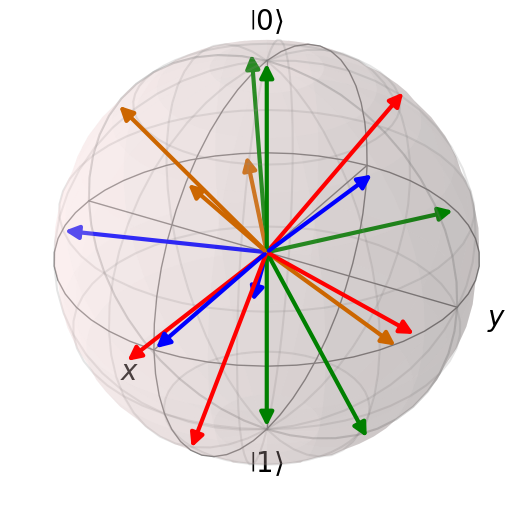

In [6]:
# Function to generate density matrix for a given Bloch vector (r_x, r_y, r_z)
def bloch_vector_to_density_matrix(r):
    I = qeye(2)  # Identity matrix
    sig_x, sig_y, sig_z = sigmax(), sigmay(), sigmaz()
    return (I + r[0] * sig_x + r[1] * sig_y + r[2] * sig_z) / 2

# Function to generate density matrices for a grid of points on the Bloch sphere
def generate_density_matrices(theta_steps, phi_steps):
    density_matrices = []
    
    # Loop over the polar angle theta (from 0 to pi)
    for i in range(theta_steps):
        theta = np.pi * i / (theta_steps - 1)  # Evenly spaced values of theta (0 to pi)
        
        # Loop over the azimuthal angle phi (from 0 to 2pi)
        for j in range(phi_steps):
            phi = 2 * np.pi * j / phi_steps  # Evenly spaced values of phi (0 to 2pi)
            
            # Compute the corresponding Bloch vector components
            r_x = np.sin(theta) * np.cos(phi)
            r_y = np.sin(theta) * np.sin(phi)
            r_z = np.cos(theta)
            
            # Create and append the density matrix
            density_matrices.append(bloch_vector_to_density_matrix((r_x, r_y, r_z)))
    
    return density_matrices

# Example: Generate a grid of 20 theta steps and 40 phi steps
theta_steps = 5  # Number of steps for theta (polar angle)
phi_steps = 5     # Number of steps for phi (azimuthal angle)
density_matrices = generate_density_matrices(theta_steps, phi_steps)

# Check that there's no repetitions
uniform_dm = []
seen_matrices = set()

for rho in density_matrices:
    matrix_repr = str(rho)  # Convert Qobj to its string representation
    if matrix_repr not in seen_matrices:
        uniform_dm.append(rho)
        seen_matrices.add(matrix_repr)

visualize_dm_on_bloch(uniform_dm)

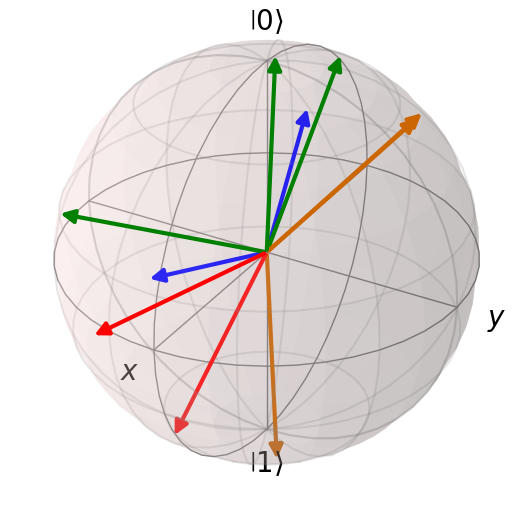

In [7]:
# Function to generate a list of uniformly random unitary operators (using Haar measure)
def generate_random_unitaries(num_units):
    unitaries = []
    for _ in range(num_units):
        unitary = rand_unitary(2)  # Random unitary matrix of size 2x2 (for qubit)
        unitaries.append(unitary)
    return unitaries

# Example: Generate 100 random unitary operators
num_units = 10
uniform_U = generate_random_unitaries(num_units)

# Visualize the effect of these unitaries on the Bloch sphere
visualize_unitaries_on_bloch(uniform_U)


In [8]:
import itertools
uniform_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(uniform_dm, uniform_U, uniform_dm)]

In [9]:
N = 100
random_data = []
for i in range(N):
    rho_exp = rand_dm(2)
    M_exp = ket2dm(rand_ket(2))
    gate_exp = rand_unitary(2)
    random_data.append([rho_exp,M_exp,gate_exp])

In [18]:
def generate_perturbed_rho(rho_ideal, perturbation_strengths):
    perturbed_rhos = []  # List to store perturbed density matrices

    for strength in perturbation_strengths:
        # Step 1: Generate a Hermitian perturbation matrix
        perturbation = strength * rand_herm(rho_ideal.shape[0])
        
        # Step 2: Apply the perturbation to the original density matrix
        perturbed_rho = rho_ideal + perturbation
        
        # Step 3: Ensure Hermiticity (average with its conjugate transpose)
        perturbed_rho = (perturbed_rho + perturbed_rho.dag()) / 2
        
        # Step 4: Ensure the density matrix is positive semi-definite
        eigenvalues = perturbed_rho.eigenenergies()
        if any(eigenvalue < 0 for eigenvalue in eigenvalues):
            # Add a small positive shift if there are negative eigenvalues
            perturbed_rho = perturbed_rho + abs(min(eigenvalues)) * identity(rho_ideal.shape[0])
        
        # Step 5: Normalize to trace 1
        perturbed_rho = perturbed_rho / perturbed_rho.tr()

        # Step 6: Append the perturbed density matrix to the list
        perturbed_rhos.append(perturbed_rho)
    
    return perturbed_rhos


def generate_perturbed_unitary(U_ideal, num_samples, noise_range=0.1):
    perturbed_unitaries = []
    
    for _ in range(num_samples):
        # Add random noise to the unitary matrix
        noise = noise_range * (np.random.rand(*U_ideal.shape) - 0.5)
        U_perturbed = U_ideal.full() + noise  # Convert to NumPy array and add noise
        
        # Perform SVD
        U, s, Vh = np.linalg.svd(U_perturbed)
        
        # Reconstruct the unitary matrix by setting singular values to 1
        U_unitary = np.dot(U, Vh)
        
        # Convert the resulting unitary matrix back to a Qobj
        U_unitary_qobj = Qobj(U_unitary)
        perturbed_unitaries.append(U_unitary_qobj)
    
    return perturbed_unitaries

perturbed_dm = generate_perturbed_rho(rho_ideal,np.linspace(0.01,0.1,20))
perturbed_U = generate_perturbed_unitary(S_gate,20)

perturbed_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(perturbed_dm, perturbed_U, perturbed_dm)]

d:\Program Files\python\Lib\site-packages\qutip\core\data\expm.py:136: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


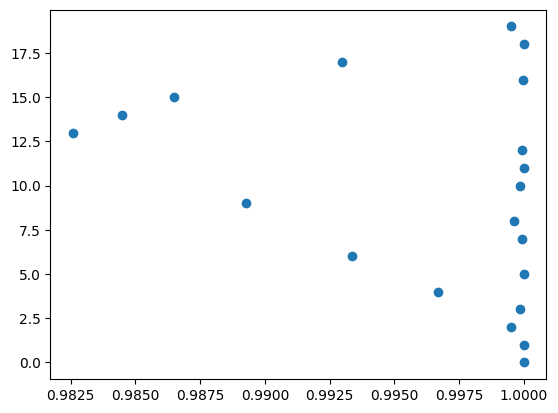

In [19]:
test_list = []
for gate in perturbed_dm:
    test_list.append(fidelity(gate, rho_ideal))

plt.scatter(test_list, range(len(test_list)))

In [20]:
# full_data = random_data + uniform_data
full_data = perturbed_data
import random
random.shuffle(full_data)

In [21]:
F = []
P = []
for datum in full_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    F.append(average_fidelity(rho_exp,gate_exp,M_exp))
    P.append(experiment_prob_failing(rho_exp,gate_exp,M_exp))

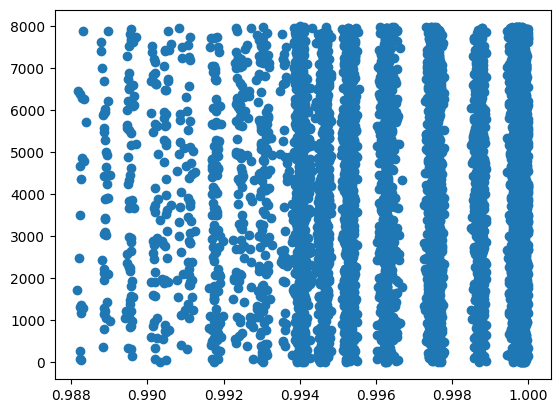

In [22]:
plt.scatter(F,range(len(F)))

In [23]:
# Convert to PyTorch tensors
X = torch.tensor(P, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F, dtype=torch.float32).unsqueeze(1)  # output: fidelity

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# Simple MLP model
# -----------------------------
# model = nn.Sequential(
#     nn.Linear(3, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
# -----------------------------
epochs = 50
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.000002
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000


In [24]:
# -----------------------------
# Test prediction
# -----------------------------
rho_exp = rand_dm(2)
M_exp = ket2dm(rand_ket(2))
gate_exp = rand_unitary(2)
test_P = torch.tensor(experiment_prob_failing(rho_exp,gate_exp,M_exp))
test_F = average_fidelity(rho_exp,gate_exp,M_exp)
pred_F = model(test_P).detach().numpy()
print("True F:", test_F)
print("Predicted F:", pred_F.flatten())


True F: 0.590929
Predicted F: [0.9991953]


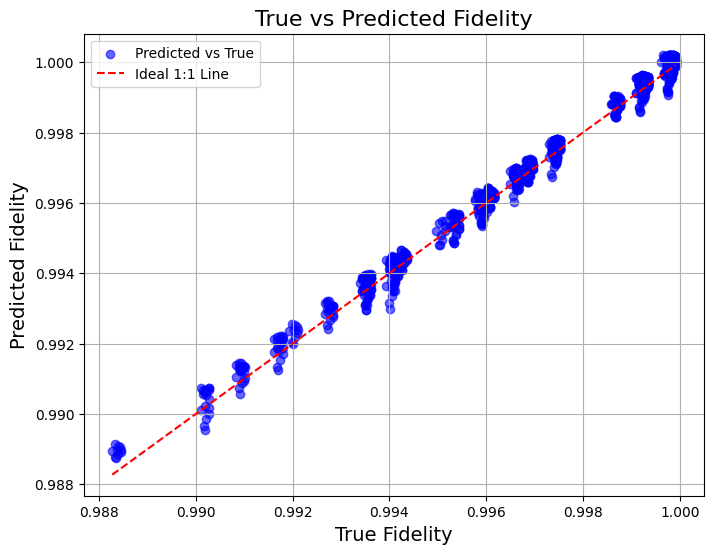

In [ ]:
# -----------------------------
# Test prediction
# -----------------------------
num_test_samples = 100  # Number of test cases
true_fidelities = []
pred_fidelities = []

perturbed_dm = generate_perturbed_rho(rho_ideal,np.linspace(0.01,0.1,10))
perturbed_U = generate_perturbed_unitary(S_gate,10)

perturbed_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(perturbed_dm, perturbed_U, perturbed_dm)]


# Loop over multiple test cases
for datum in perturbed_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    # Get the test probability and fidelity
    test_P = torch.tensor(experiment_prob_failing(rho_exp, gate_exp, M_exp)).unsqueeze(0)  # Batch dimension (1 sample)
    test_F = average_fidelity(rho_exp, gate_exp, M_exp)

    # Get the model prediction
    pred_F = model(test_P).detach().numpy().flatten()

    # Store the results
    true_fidelities.append(test_F)
    pred_fidelities.append(pred_F)

# Convert lists to numpy arrays for plotting
true_fidelities = np.array(true_fidelities)
pred_fidelities = np.array(pred_fidelities)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(true_fidelities, pred_fidelities, color='blue', label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(true_fidelities), max(true_fidelities)], [min(true_fidelities), max(true_fidelities)], 'r--', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("True Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("True vs Predicted Fidelity", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()